<div class="usecase-title">{Events at Argyle Squrae}</div>

<div class="usecase-authors"><b>Authored by: </b> {Alison Collins}</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python}</div>
</div>

<div class="usecase-section-header">Scenario</div>

If you are planning an event at Argyle Square you will need to know approximate numbers of attendees and if you need to hire additional bins. This use case seeks to find if there is a relationship between stage use, number of attendees and bin capacity at Argyle Square, and use this knowledge to make predictions.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- {list the skills demonstrated in your use case}

<div class="usecase-section-header">{Heading for introduction or background relating to problem}</div>

{Write your introduction here. Keep it concise. We're not after "War and Peace" but enough background information to inform the reader on the rationale for solving this problem or background non-technical information that helps explain the approach. You may also wish to give information on the datasets, particularly how to source those not being imported from the client's open data portal.}



Required modules

In [634]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore")

# Import required modules
import requests
import numpy as np
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
from sklearn import datasets

Import datasets using API v2.1 GET request with /exports/

In [2]:
from io import StringIO

# Function to collect datasets using API
def datasetcollect(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = " "
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [3]:
# Import stage activity dataset
dataset_id = 'meshed-sensor-type-3'
stage_activity_all = datasetcollect(dataset_id)
print(len(stage_activity_all))
stage_activity_all.head(3)

350920


,dev_id,sensor_name,time,temperature,humidity,light,motion,visit,vdd,lat_long
0,ers-55eb,NaN,2022-12-13T20:09:42+00:00,10.5,89,297,0,0,3638,NaN
1,ers-55ea,NaN,2022-12-13T20:26:03+00:00,10.6,88,136,0,0,3635,NaN
2,ers-55eb,NaN,2022-12-13T20:34:47+00:00,10.8,89,698,0,0,3638,NaN


In [4]:
# Import bin sensor dataset
dataset_id = 'netvox-r718x-bin-sensor'
bin_sensor_all = datasetcollect(dataset_id)
print(len(bin_sensor_all))
bin_sensor_all.head(3)

561783


,dev_id,time,temperature,distance,filllevel,battery,lat_long,sensor_name,fill_level
0,r718x-6778,2023-02-26T08:16:47+00:00,19.0,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
1,r718x-6f16,2023-02-26T08:18:10+00:00,19.9,202.0,74.0,3.6,"-37.8028794, 144.9662728",r718x-bin sensor 17,72.0
2,r718x-677d,2023-02-26T08:18:02+00:00,20.7,200.0,74.0,3.6,"-37.8021051, 144.9654523",r718x-bin sensor 11,72.0


In [5]:
# Import blix mobile phone counter dataset
dataset_id = 'blix-visits'
blix_phones_all = datasetcollect(dataset_id)
print(len(blix_phones_all))
blix_phones_all.head(3)

109175


,datetime,keys1,total,dwell,sensor_name,sensor_type,lat_long,avg_dwell
0,2022-08-25T22:00:00+00:00,8171,27,5697,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",3.0
1,2022-08-26T08:00:00+00:00,8171,115,42090,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",6.0
2,2022-08-26T02:00:00+00:00,7780,228,94848,Pedestrian Sensor-Argyle Sq,Mobile phone counting,"-37.8025805, 144.9656012",6.0


Preprocessing of datasets

In [656]:
# Delete unwanted columns from datasets

# Drop columns from stage_activity dataframe
stage_activity = stage_activity_all[['dev_id','time','motion','visit','temperature','humidity','light']]
# Drop columns from stage_activity dataframe
bin_sensor_cols = bin_sensor_all[['dev_id','time','filllevel']]
# Drop columns from stage_activity dataframe
blix_phones = blix_phones_all[['datetime','keys1','total','dwell','avg_dwell']]

In [657]:
# check data types in columns

print("Data types in Stage activity")
print(stage_activity.dtypes)

print("Data types in Bin Sensor")
print(bin_sensor_cols.dtypes)

print("Data types in Blix Phones")
print(blix_phones.dtypes)

Data types in Stage activity
dev_id          object
time            object
motion           int64
visit            int64
temperature    float64
humidity         int64
light            int64
dtype: object
Data types in Bin Sensor
dev_id        object
time          object
filllevel    float64
dtype: object
Data types in Blix Phones
datetime      object
keys1          int64
total          int64
dwell          int64
avg_dwell    float64
dtype: object


In [658]:
# convert date time columns to date time type

stage_activity['date_time'] = pd.to_datetime(stage_activity['time'])
stage_activity = stage_activity.drop(['time'], axis=1)

bin_sensor_cols['date_time'] = pd.to_datetime(bin_sensor_cols['time'])
bin_sensor_cols = bin_sensor_cols.drop(['time'], axis=1)

blix_phones['date_time'] = pd.to_datetime(blix_phones['datetime'])
blix_phones = blix_phones.drop(['datetime'], axis=1)

In [659]:
#Check oldest and most recent dates in datasets

print("Date range in stage activity")
print(stage_activity["date_time"].min())
print(stage_activity["date_time"].max())

print("Date range in bin sensor")
print(bin_sensor_cols["date_time"].min())
print(bin_sensor_cols["date_time"].max())

print("Date range in blix phones")
print(blix_phones["date_time"].min())
print(blix_phones["date_time"].max())

Date range in stage activity
2022-11-29 06:05:16+00:00
2024-03-27 07:28:36+00:00
Date range in bin sensor
2023-02-26 08:16:37+00:00
2024-03-27 07:29:17+00:00
Date range in blix phones
2021-12-31 13:00:00+00:00
2024-03-26 12:00:00+00:00


In [660]:
# Drop rows so that all datasets have the same date range

stage_activity= stage_activity[(stage_activity['date_time'] > '2023-2-26') & (stage_activity['date_time'] <= '2024-3-26')]

bin_sensor= bin_sensor_cols[(bin_sensor_cols['date_time'] > '2023-2-26') & (bin_sensor_cols['date_time'] <= '2024-3-26')]

blix_phones= blix_phones[(blix_phones['date_time'] > '2023-2-26') & (blix_phones['date_time'] <= '2024-3-26')]


In [661]:
# BIN DATASET PREPROCESSING
# Filter unwanted values from bin dataset 

# Keep only rows with bin sensors in the stage area
filtered_bin_sensor = bin_sensor_cols[bin_sensor_cols["dev_id"].isin(["r718x-6778", "r718x-6775","r718x-6f25","r718x-677e","r718x-6f31"])]
filtered_bin_sensor.head(3)

# Check max and min values in bin fill levels
# Max and min of filllevel column
print(filtered_bin_sensor['filllevel'].agg(['min', 'max']))

# Count the number of values greater than 100 in the bin fill coumns
more = len(filtered_bin_sensor[filtered_bin_sensor['filllevel']>100])

# Fnd percentage of values impacted  by value >100 in fill level
# Count the number of rows in the dataframe
total = len(filtered_bin_sensor)
#check the length of the dataframe
print(len(filtered_bin_sensor))
# Calculate the percentage of data that has values greater than 100
print(more/total)

# As only 0.0456% of data is impacted by data inaccuracies, make the decision to drop these rows from the table.

# Drop rows where bin fill column is greater than 100
filtered_bin_sensor = filtered_bin_sensor.drop(filtered_bin_sensor[filtered_bin_sensor['filllevel'] > 100].index)
# Check the length of the dataframe
len(filtered_bin_sensor)


min      0.0
max    255.0
Name: filllevel, dtype: float64
133765
0.0004560236235188577


133704

In [662]:
# BIN DATASET PREPROCESSING: RESAMPLE HOURLY FILLLEVEL MAX WITHOUT GROUPING BY BIN

# Set index to datetime column
filtered_bin_sensor.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_bin_sensor1 = filtered_bin_sensor.resample('H').filllevel.max()
grouped_bin_sensor1.head(3)

date_time
2023-02-26 08:00:00+00:00    74.0
2023-02-26 09:00:00+00:00    74.0
2023-02-26 10:00:00+00:00    74.0
Freq: H, Name: filllevel, dtype: float64

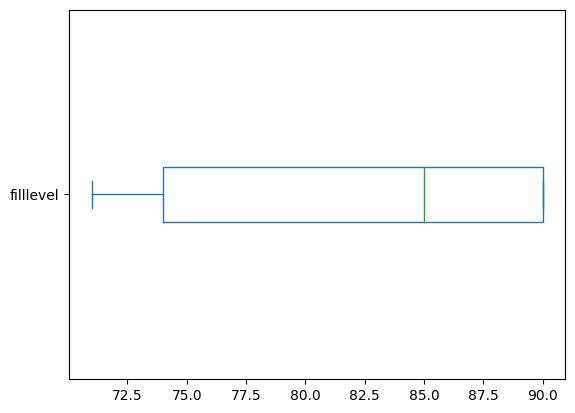

In [663]:
# Visual check of data with boxplot
grouped_bin_sensor1.plot(kind='box', vert=False)
plt.show()

In [664]:
# STAGE ACTIVITY DATASET PREPROCESSING: RESAMPLE HOURLY MAX WITHOUT GROUPING BY SENSOR

# Set index to datetime column
stage_a = stage_activity
stage_a.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_stage_activity = stage_a.resample('H').agg({'motion':'max','temperature':'mean','humidity':'mean','light':'mean'})
grouped_stage_activity.head(3)

,motion,temperature,humidity,light
date_time,,,,
2023-02-26 00:00:00+00:00,0.0,21.913333,56.900000,2080.466667
2023-02-26 01:00:00+00:00,1.0,23.612500,51.156250,2187.687500
2023-02-26 02:00:00+00:00,1.0,24.703226,49.322581,2069.096774


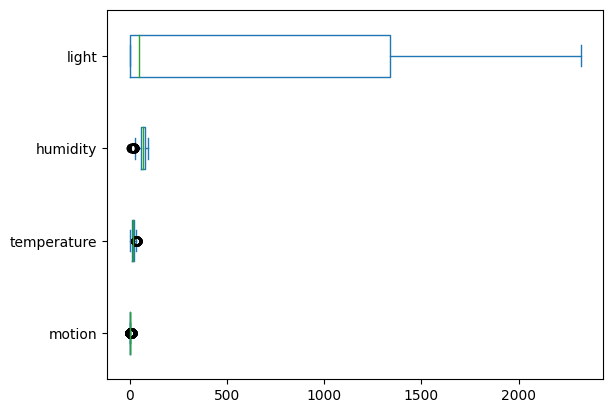

In [665]:
# Visual check of data with boxplot

grouped_stage_activity.plot(kind='box', vert=False)
plt.show()

In [666]:
# Merge grouped bin sensor and stage activity

merged_dataframe_A = pd.merge(grouped_bin_sensor1, grouped_stage_activity, on="date_time",how='outer')
merged_dataframe_A.head(3)

,filllevel,motion,temperature,humidity,light
date_time,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333


In [667]:
# BLIX_PHONE DATASET PREPROCESSING: Filter unwated data

# Keep only rows with sensores in the stage area
filtered_blix_phone = blix_phones[blix_phones["keys1"].isin([7780])]
filtered_blix_phone.head(3)

,keys1,total,dwell,avg_dwell,date_time
32826,7780,223,44377,3.0,2023-02-26 07:00:00+00:00
32828,7780,237,88638,6.0,2023-02-26 06:00:00+00:00
32833,7780,186,72726,6.0,2023-02-26 05:00:00+00:00


In [668]:
# BLIX PHONES DATASET ALREADY SAMPLED BY HOUR

# Set filtered_blix_phones index to datetime column
filtered_blix_phone.set_index('date_time', inplace=True)

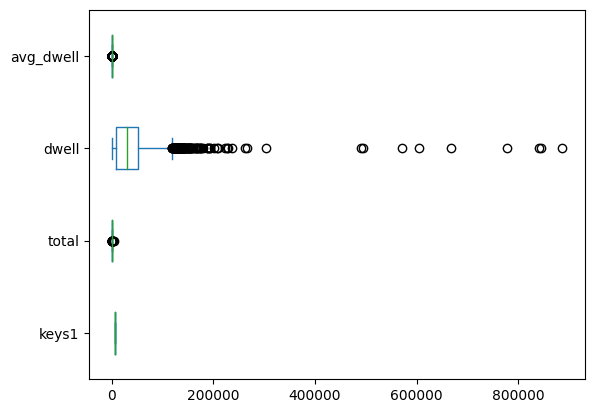

In [669]:
# Visual check of data with boxplot

filtered_blix_phone.plot(kind='box', vert=False)
plt.show()

In [670]:
# Some very high valued outliers in dwell data, remove values above 400000
filtered_blix_phone = filtered_blix_phone.drop(filtered_blix_phone[filtered_blix_phone['dwell'] > 400000])

KeyError: "['keys1', 'total', 'dwell', 'avg_dwell'] not found in axis"

In [ ]:
# Merge dataframes

# Merge grouped stage activity, grouped bin sensor and grouped blix phones
merged_dataframe = pd.merge(merged_dataframe_A, filtered_blix_phone[['total','dwell','avg_dwell']], on="date_time",how='outer')
merged_dataframe.head(3)


,filllevel,motion,temperature,humidity,light,total,dwell,avg_dwell
date_time,,,,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,46020.0,4.0
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,37949.0,4.0
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,15708.0,3.0


In [ ]:
# Count the number of rows with NaN values in any column
merged_dataframe.isna().any(axis=1).sum()



372

In [ ]:
# Find the lenth of the merged dataframe
len(merged_dataframe.index)

9488

Feature Correlation

In [ ]:
# Add an index column to allow feature corelation with time as well
merged_dataframe = merged_dataframe.reset_index()
print(merged_dataframe.dtypes)
merged_dataframe.head(3)


date_time      datetime64[ns, UTC]
filllevel                  float64
motion                     float64
temperature                float64
humidity                   float64
light                      float64
total                      float64
dwell                      float64
avg_dwell                  float64
dtype: object


,date_time,filllevel,motion,temperature,humidity,light,total,dwell,avg_dwell
0,2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,46020.0,4.0
1,2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,37949.0,4.0
2,2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,15708.0,3.0


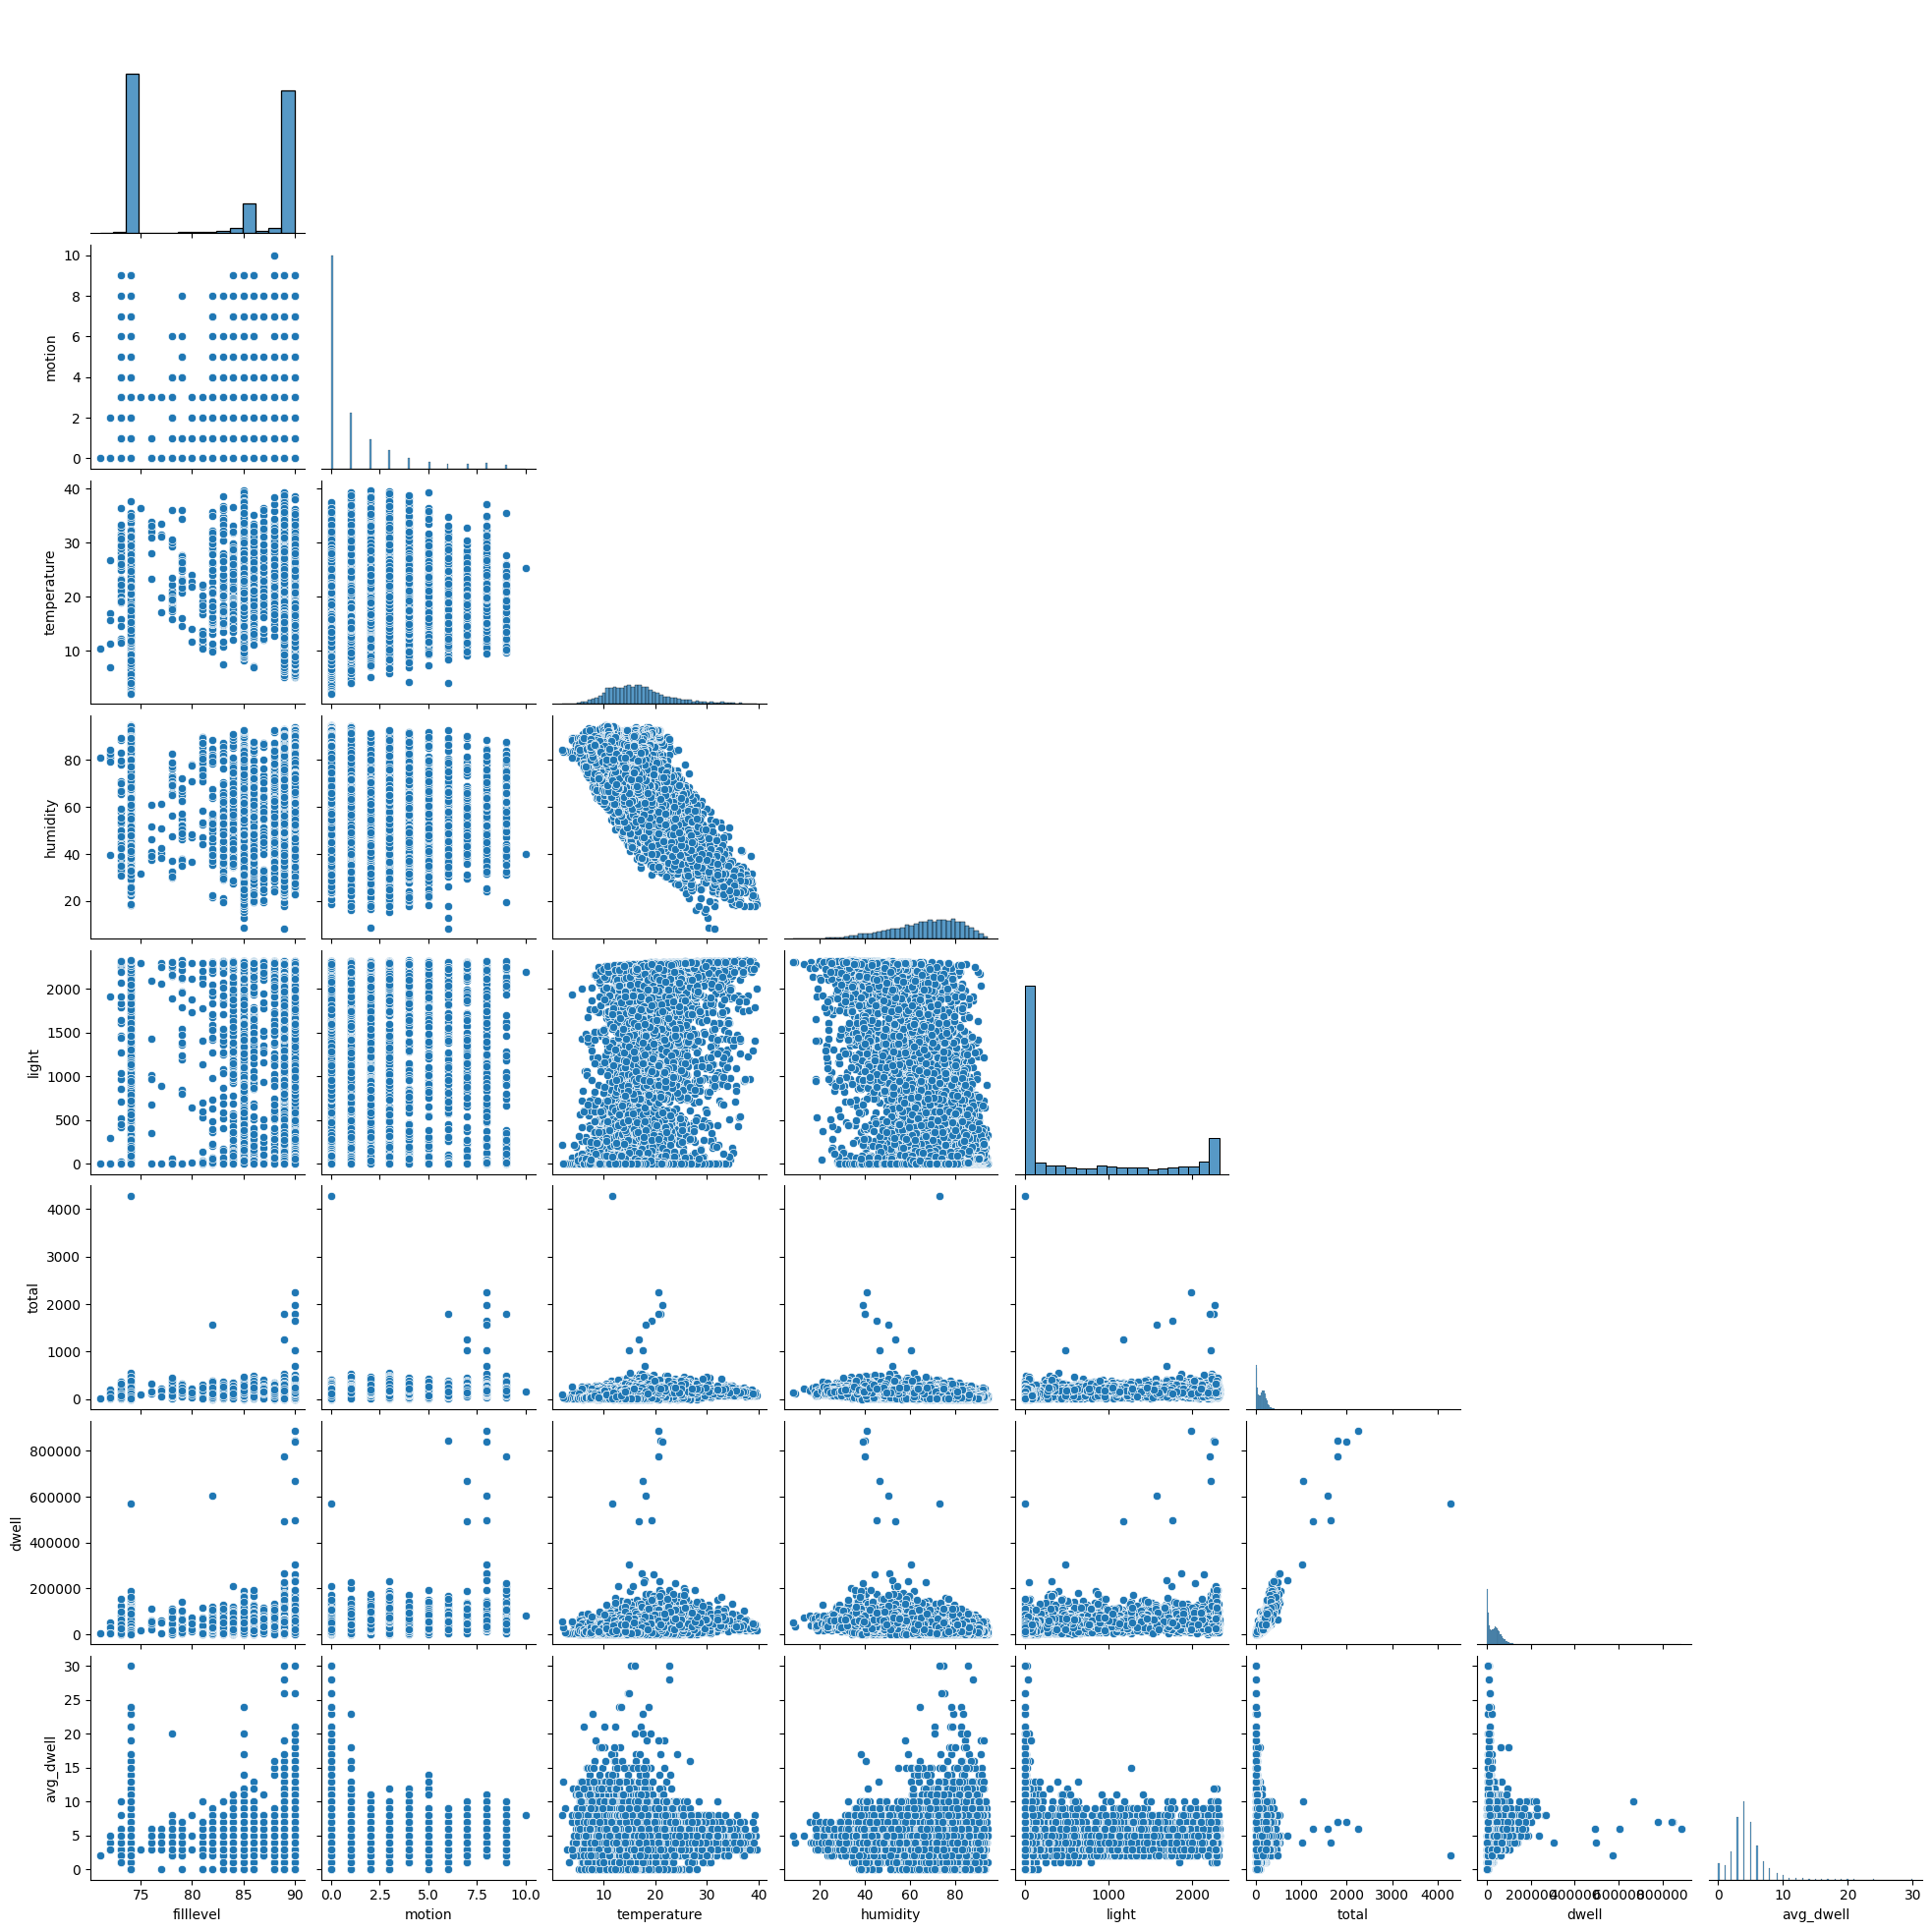

In [ ]:
# Create a pairsplot to look at relationships between variables
sns.pairplot(merged_dataframe, corner=True)
plt.show()

The pairs plot produced above shows the relationships between each numerical variable in the dataset. It can be seen from this that there is an extreme outlier in the total data column. This value will be removed and the pairs plot called again.

In [ ]:
# Drop rows where total > 4000
filtered_merged_dataframe = merged_dataframe.drop(merged_dataframe[merged_dataframe['total'] > 4000].index)

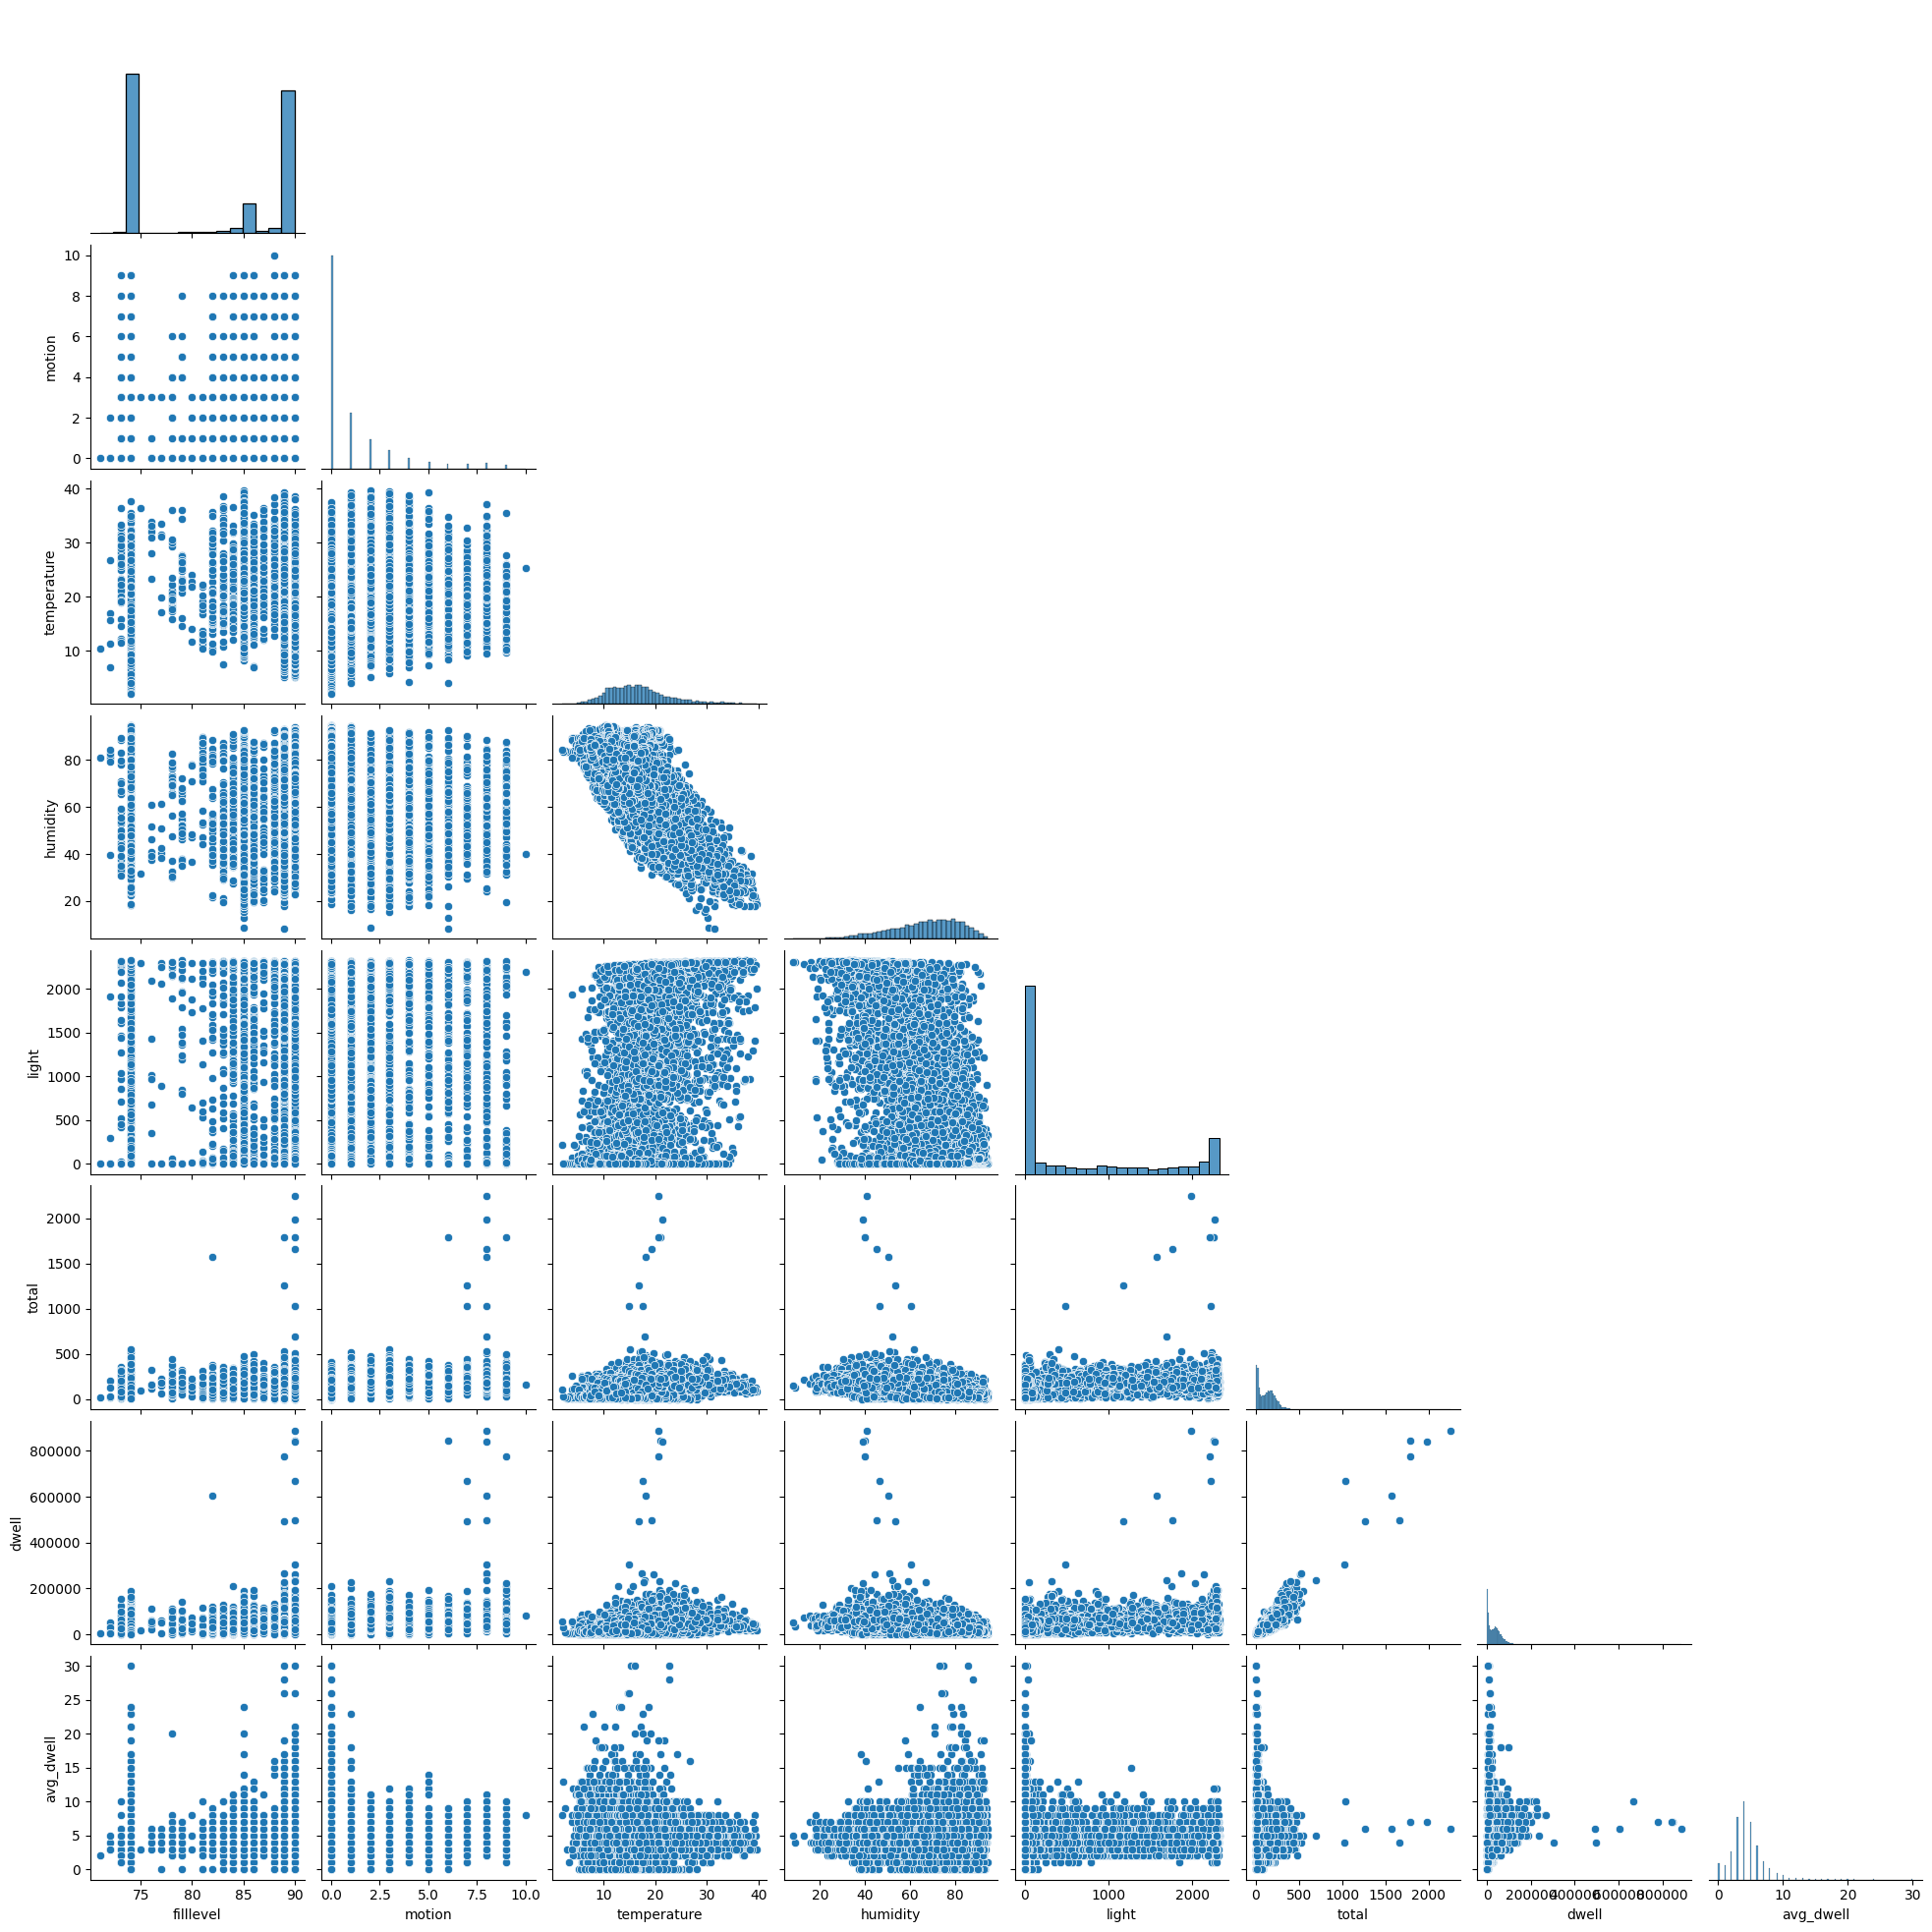

In [ ]:
# Create a pairsplot to look at relationships between variables
sns.pairplot(filtered_merged_dataframe, corner=True)
plt.show()

The pairs plot shows a relationship between some variables. Temperature, humidity and light have the strongest relationship. The strongest linear relationship is between total and dwell.

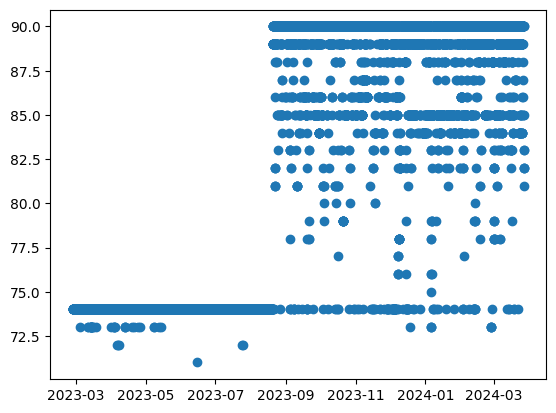

In [ ]:
# Create scatter plots of datetime vs all other variables
# Create a plot of time vs fill level
plt.scatter(filtered_merged_dataframe['date_time'], filtered_merged_dataframe['filllevel'])
plt.show()

 From this data it is evident that from 2023-08 the bins were more likely to have higher fill values.As 2023-03 and 2024-03 do not have similar fill value patterns, the data prior to 2023-08-20 will be dropped from the table to determine if clearer patterns emerge from the most recent data.

In [ ]:
fmdd = filtered_merged_dataframe[(filtered_merged_dataframe['date_time'] > '2023-08-20')]

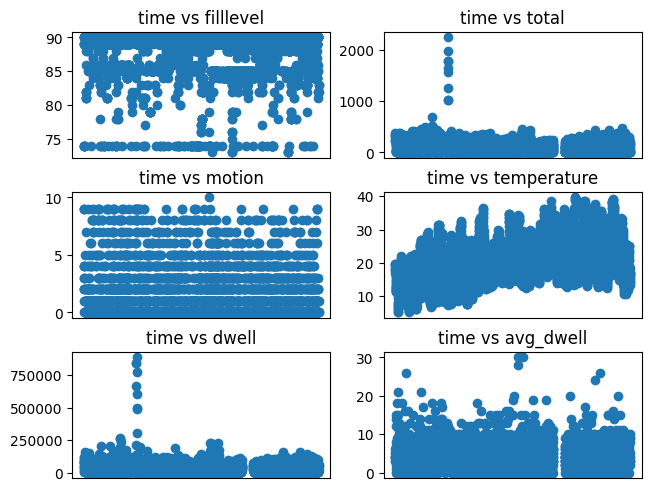

In [ ]:
# Create scatter plots of datetime vs all other variables
fig, ax = plt.subplots(3, 2,constrained_layout = True)
# Create a plot of time vs filllevel
plt.subplot(3,2,1)
plt.scatter(fmdd['date_time'], fmdd['filllevel'])
plt.title("time vs filllevel")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs total
plt.subplot(3,2,2)
plt.scatter(fmdd['date_time'],fmdd['total'])
plt.title("time vs total")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs motion
plt.subplot(3,2,3)
plt.scatter(fmdd['date_time'],fmdd['motion'])
plt.title("time vs motion")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs temperature
plt.subplot(3,2,4)
plt.scatter(fmdd['date_time'], fmdd['temperature'])
plt.title("time vs temperature")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs dwell
plt.subplot(3,2,5)
plt.scatter(fmdd['date_time'],fmdd['dwell'])
plt.title("time vs dwell")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# Create a plot of time vs avg_dwell
plt.subplot(3,2,6)
plt.scatter(fmdd['date_time'], fmdd['avg_dwell'])
plt.title("time vs avg_dwell")
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()


From the scatterplots against time, the only linear relationship evident is that of time against average dwelling. However, as the time range includes only August through March (the warmer months), seasonality cannot be accounted for and the drop at the end may be due to a seasonal trend.

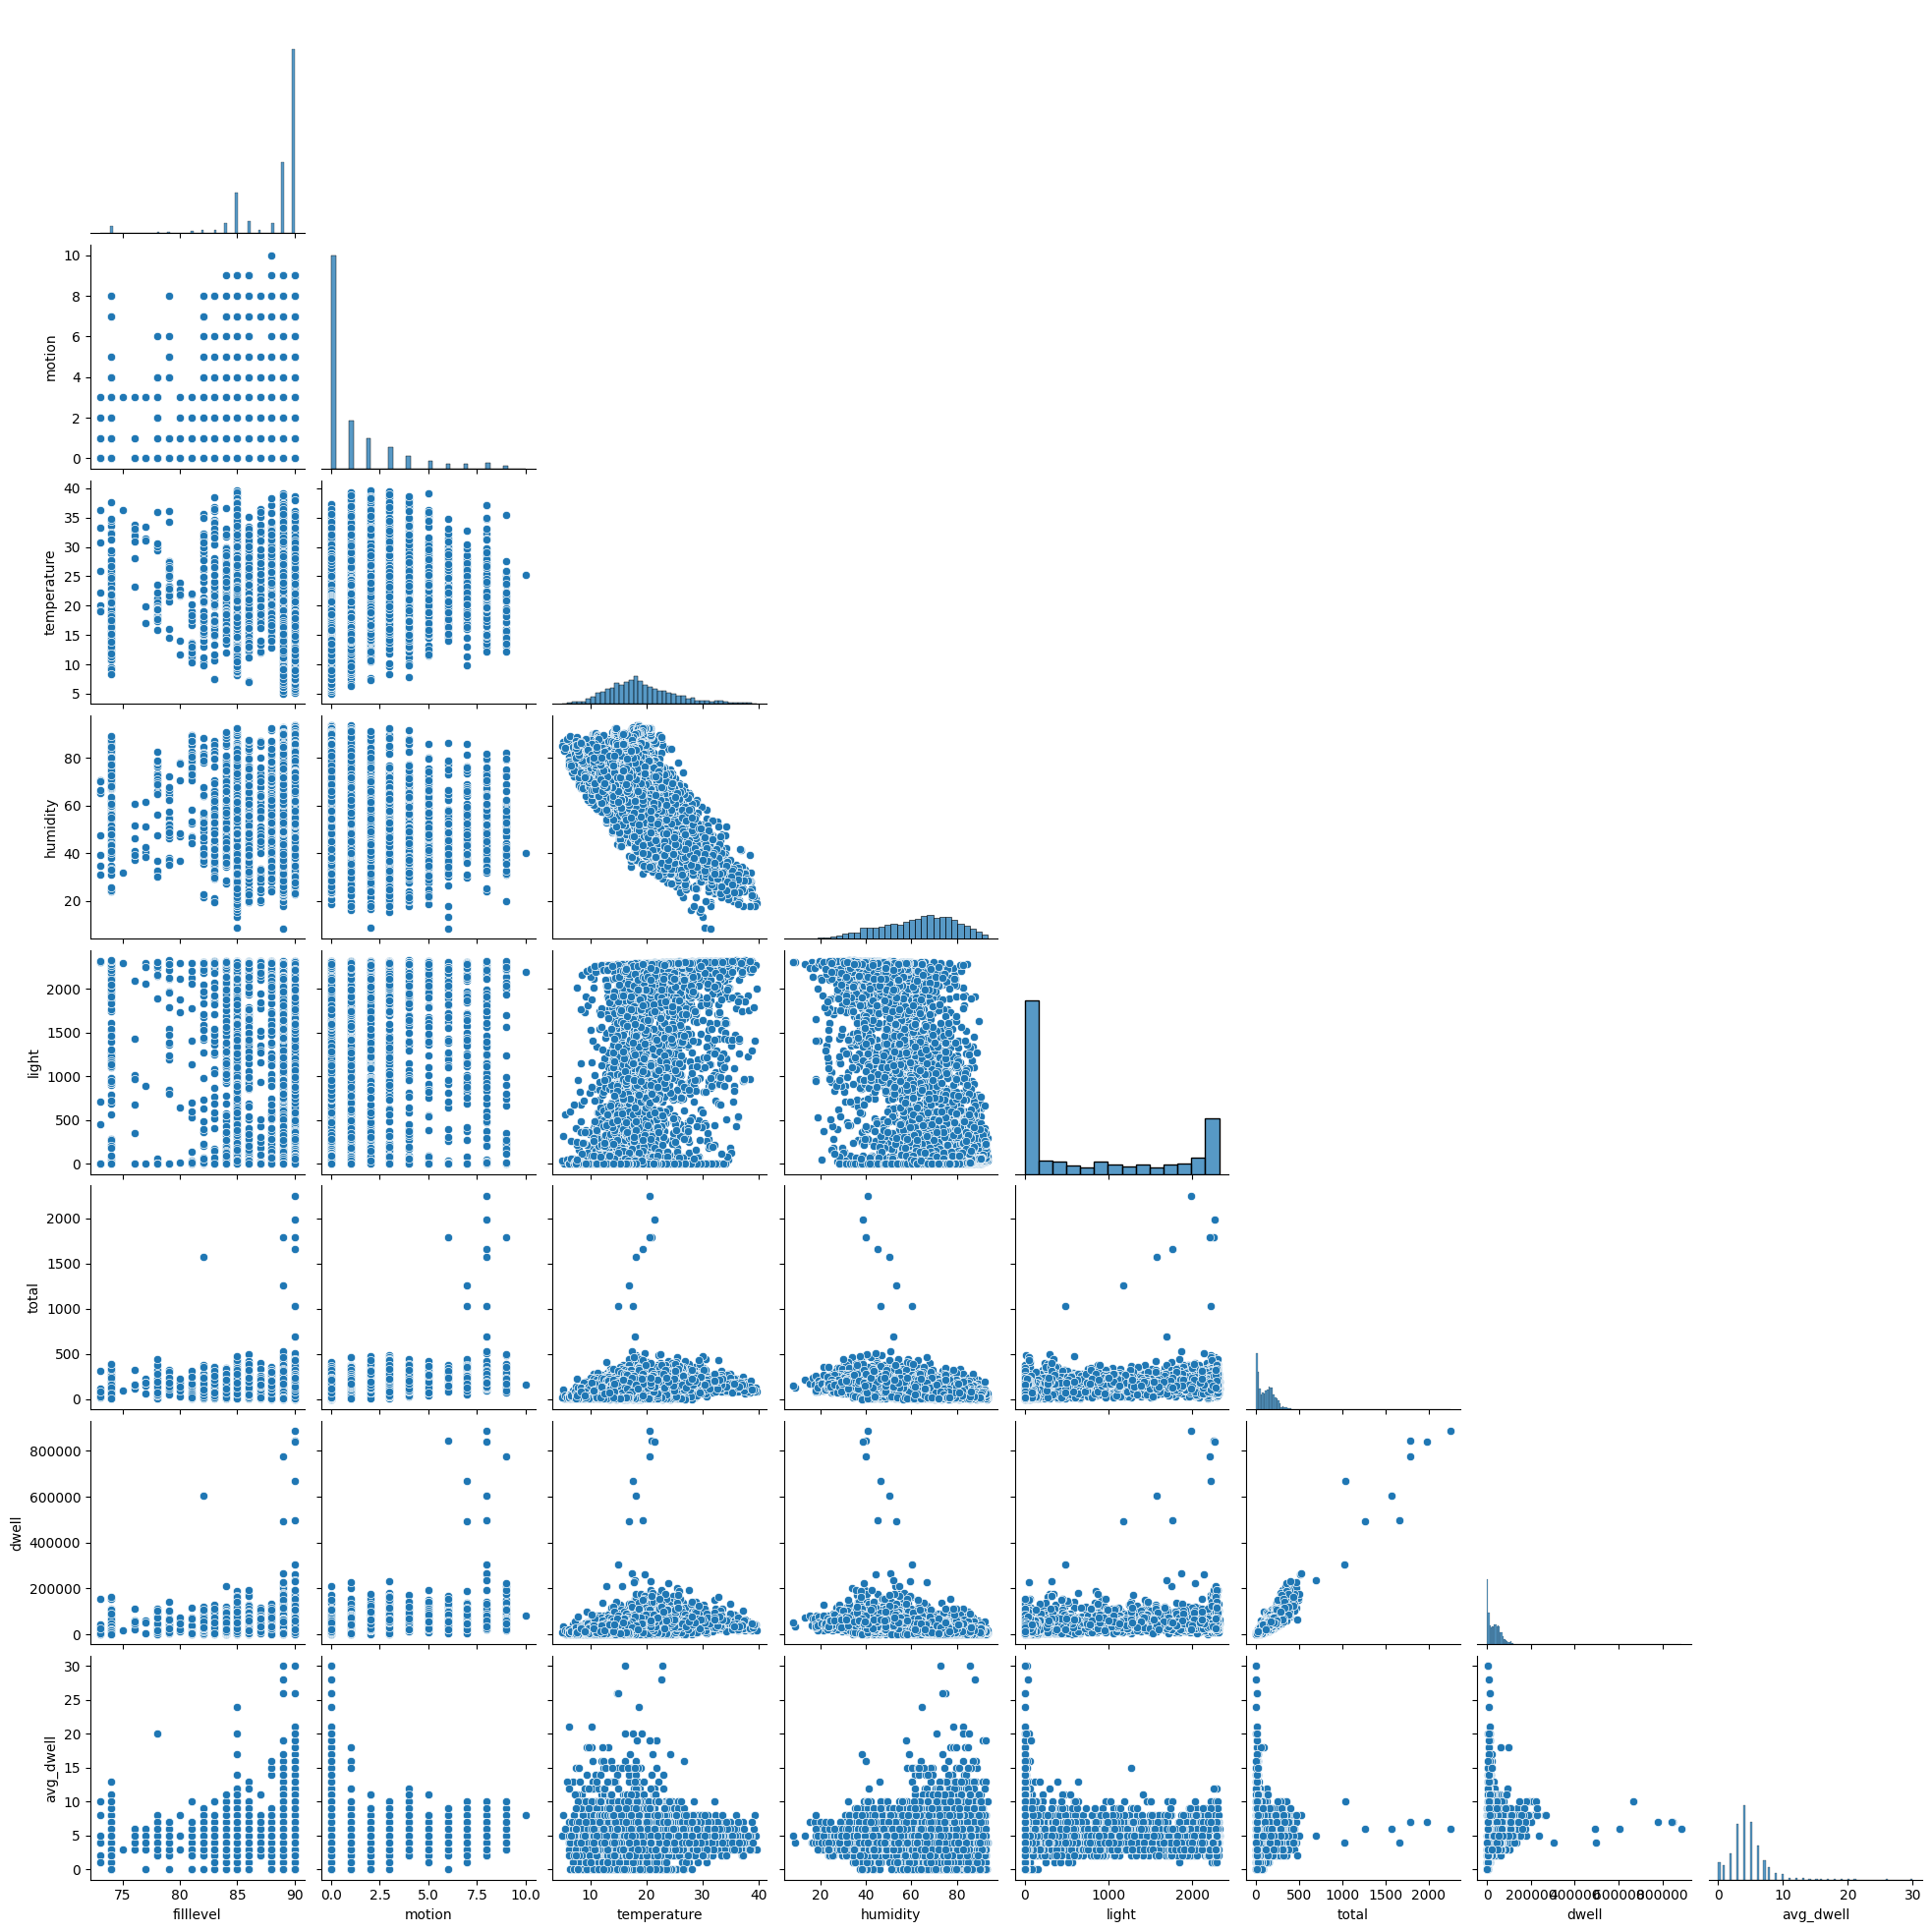

In [ ]:
# Create a pairsplot to look at relationships between other variables
sns.pairplot(fmdd, corner=True)
plt.show()

Spearman correlation is used to determine extent of linear relationship between each pair of variables. This is used as date_time is a categorical data type (every hour) and all other assumptions for Spearman correlation are assumed met.

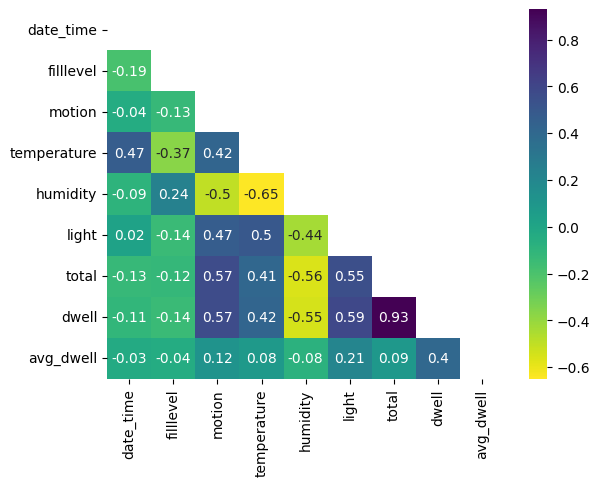

In [ ]:
# Calculate correlation heatmap for all columns
matrix = fmdd.corr(method = 'spearman').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, cmap='viridis_r', mask=mask)

plt.show()

The correlation heatmap shows the linear relationship between the variables. In this investigation the focus is on the relationship between fill level and other variables. The highest linear relationship is between temperature and bin fill level, with has a medium negative linear correlation of -0.37, followed by other weather related variables. Motion, dwelling and total are seen to have weak negative linear relationships with bin filllevel.  

As few variables exhibit a strong linear relationship in the heatmap or pairplot, the existance of non-linear relationships should also be measured. The Distance Correlation uses the dcor package to help capture the extent of non-linear correlation between variables. As bin filllevel is the main variable of interest, measurements of each varaibles correlation to filllevel will be calculated.

In [ ]:
# Calculated non-linear distance correlation between all variables and bin filllevel

# Drop rows with na values (not supported in dcor package)
no_na_fmdd = fmdd.dropna(axis=0, how='any')

# Calculate distance correlation between numerical variables and bin fill level (Datetime not supported)
print("filllevel and total =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['total']))
print("filllevel and dwell =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['dwell']))
print("filllevel and avg_dwell =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['avg_dwell']))
print("filllevel and motion =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['motion']))
print("filllevel and temperature =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['temperature']))
print("filllevel and humidity =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['humidity']))
print("fillevel and light =" , dcor.distance_correlation(no_na_fmdd['filllevel'],no_na_fmdd['light']))


filllevel and total = 0.12399388699239815
filllevel and dwell = 0.1328101205651308
filllevel and avg_dwell = 0.060555442704706225
filllevel and motion = 0.11705507947700061
filllevel and temperature = 0.30143662635256
filllevel and humidity = 0.22751679493296822
fillevel and light = 0.16168599330119496


The strongest non-linear correlations measured remain between bin filllevel and weather variables of temperature, humidity and light. As with the linear correlation measurement, the distance correlation also finds slight non-linear relationships between total, dwell and motion.

Predictions for bin full - linear

In [ ]:
# code for linear

Predictions for bin full - classification

In [ ]:
# Target varaible is last column of dataset, so move fill level to last column

In [ ]:
#!jupyter nbconvert --to html usecase_TEMPLATE_COPY.ipynb